In [240]:
import os
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
import tensorflow_datasets as tfds
%matplotlib inline

In [241]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [242]:
data_dir ='./'
training_data_path = "original_sound_png"
test_data_path = "converted_sound_png"

color_mode = "rgb"
number_color_channels = 3
image_size = (640, 480)
image_shape = image_size + (number_color_channels,)

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.1
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset

    )
    
    raw_data_set.class_names.sort()
    print(raw_data_set)
    return {
        "data": raw_data_set,
        "classNames": raw_data_set.class_names
    }

In [243]:
train_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "training"
)
validation_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "validation"
)
test_set = get_image_data(
    test_data_path,
    color_mode,
    image_size
)

Found 40 files belonging to 4 classes.
Using 36 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 640, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Found 40 files belonging to 4 classes.
Using 4 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 640, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Found 1240 files belonging to 4 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 640, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [244]:
# Class Sanity Check
equivalence_check = train_set["classNames"] == validation_set["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = train_set["classNames"]
number_classes = len(class_names)

In [245]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape = image_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_classes)
])

In [246]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [247]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 640, 480, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 640, 480, 16)      448       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 320, 240, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 320, 240, 32)      4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 160, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 160, 120, 64)    

In [248]:
epochs = 15
history = model.fit(
  train_set['data'],
  validation_data = validation_set['data'],
  epochs=epochs,
)

Epoch 1/15


2023-04-25 16:21:12.324124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 463ms/step - loss: 6.3951 - accuracy: 0.2222 - val_loss: 25.6914 - val_accuracy: 0.2500
Epoch 2/15


2023-04-25 16:21:13.887498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 122ms/step - loss: 23.7680 - accuracy: 0.2500 - val_loss: 4.4475 - val_accuracy: 0.2500
Epoch 3/15
2/2 [==============================] - 0s 120ms/step - loss: 4.5364 - accuracy: 0.1944 - val_loss: 2.3306 - val_accuracy: 0.2500
Epoch 4/15
2/2 [==============================] - 0s 126ms/step - loss: 2.3071 - accuracy: 0.2500 - val_loss: 1.4035 - val_accuracy: 0.5000
Epoch 5/15
2/2 [==============================] - 0s 111ms/step - loss: 1.3792 - accuracy: 0.4444 - val_loss: 1.3183 - val_accuracy: 0.2500
Epoch 6/15
2/2 [==============================] - 0s 113ms/step - loss: 1.2003 - accuracy: 0.5278 - val_loss: 1.4547 - val_accuracy: 0.2500
Epoch 7/15
2/2 [==============================] - 0s 109ms/step - loss: 1.1775 - accuracy: 0.3889 - val_loss: 1.1230 - val_accuracy: 0.7500
Epoch 8/15
2/2 [==============================] - 0s 109ms/step - loss: 0.8258 - accuracy: 0.7222 - val_loss: 1.0449 - val_accuracy: 0.5000
Epoch 9/15
2/2 [==============

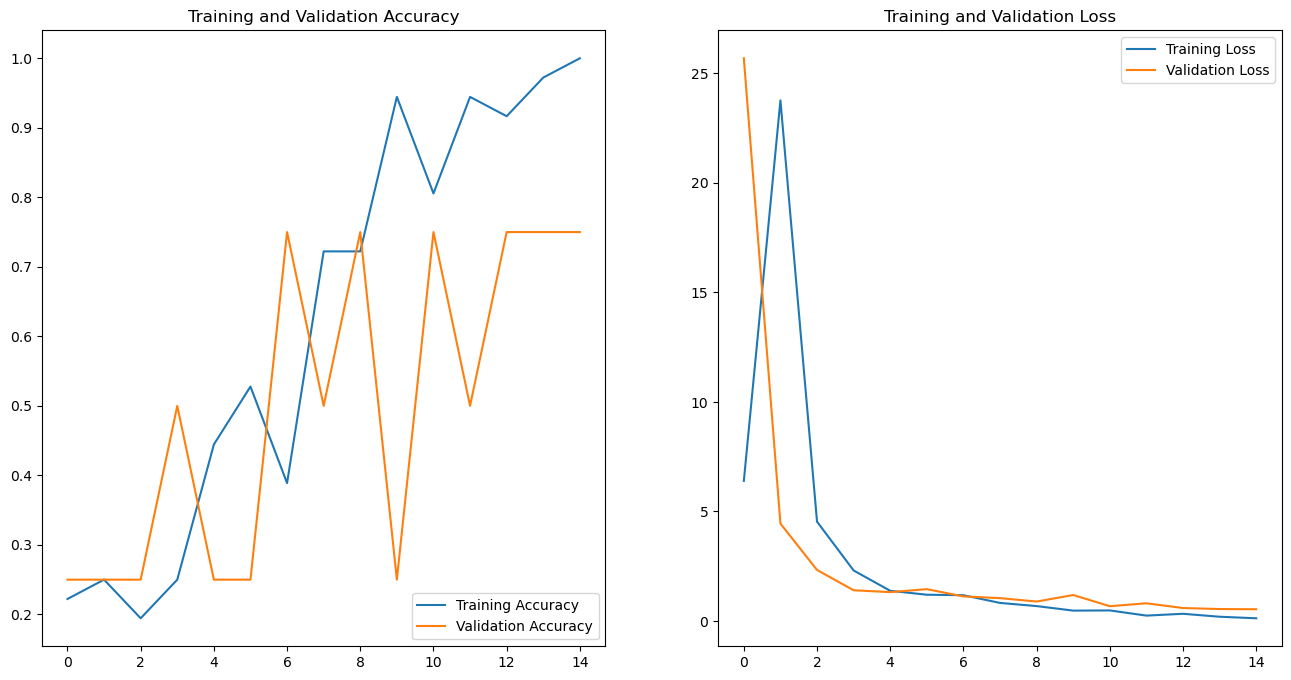

In [249]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [250]:
accuracy = model.evaluate(test_set['data'])

39/39 [==============================] - 4s 99ms/step - loss: 2.4012 - accuracy: 0.3589


In [251]:
targets = []
results = []
for batch in test_set['data']:
    targets.extend(batch[1].numpy().tolist())
    predictions = [np.argmax(p) for p in model.predict(batch[0])]
    results.extend(predictions)
y_pred = np.array(results)
y_test = np.array(targets)

1/1 [==============================] - 0s 139ms/step


2023-04-25 16:21:24.480148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 138ms/step


2023-04-25 16:21:30.447062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.3588709677419355
              precision    recall  f1-score   support

           0       0.31      0.26      0.28       310
           1       0.38      0.33      0.35       310
           2       0.46      0.75      0.57       310
           3       0.16      0.11      0.13       310

    accuracy                           0.36      1240
   macro avg       0.33      0.36      0.33      1240
weighted avg       0.33      0.36      0.33      1240



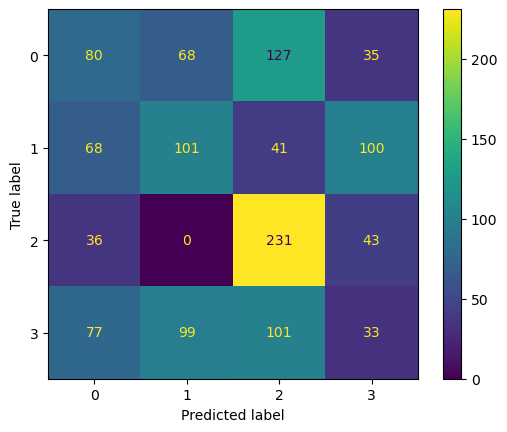

In [252]:
print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()